In [3]:
import os
project_root = os.pardir
import sys
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

import random as rand
import networkx as nx
import data.make_dataset_classes as dat
from data.make_dataset_classes import *
import collections as col
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import tqdm

In [6]:
class LFN:
    '''
    Class of Labour Flow Networks. Includes methods for creating, modifying,
    and drawing information from Labour Flow Networks.

    - Inherit from the class of networkx networks.
    - Make method: Create an LFN for the years specified
    - FilepathInfo method: return a string to be used as part of a filename
    specifying the key details of the LFN

    Node Attributes:
        'Dead': dictionary mapping every node to True if node is dead or False
        if node is alive.

    Data Attributes
        dead_nodes: set of dead nodes.
    '''

    def __init__(
                self,
                flow_years, nflow_rows=None,
                death_years=None, ndeath_rows=None,
                show_info=True
                ):
        '''
        Create LFN from specified flowyears and add corresponding filepath info.
        If deathyears provided add dead_ids and dead_nodes data attributes
        and mark dead nodes in graph as dead.
        '''

        #make LFN from flow years
        self.graph = MakeLFN(flow_years, nrows=nflow_rows, print_info=False)
        #change graph name to remove info about flow years. This is to avoid
        #possible inconsistencies with the self.flow_years attribute after merging
        #lfns
        self.graph.name = 'Labour Flow Network'
        #set flow years attribute
        self.flow_years = flow_years
        #set all firms by default to alive
        self.AllAlive()
        #initialise dead ids and dead nodes attributes to empty
        self.dead_ids = set()
        self.dead_nodes = set()
        #set death years attribute
        self.death_years = str(death_years)
        if death_years != None:
            self.dead_ids = GetDeadIds(
                                    death_years=death_years, nrows=ndeath_rows
                                    )
            self.dead_nodes = set(DeadInLFN(self.graph, self.dead_ids))
            self.KillNodes(self.dead_nodes)
        self.CheckConsistency()
        if show_info == True:
            self.PrintInfo()

    def PrintInfo(self):
        '''
        Print info on LFN.
        '''
        print(nx.info(self.graph))
        print('Death Years: ' + self.death_years)
        print('Flow Years: ' + self.flow_years)
        print('============================')

    def AllAlive(self):
        '''
        Sets node attributes so that all nodes are marked as alive.
        '''
        dead_dict = dict()
        for node in self.graph.nodes():
            dead_dict[node] = False
        nx.set_node_attributes(self.graph, 'Dead', dead_dict)

    def KillNodes(self, dead_ids):
        '''
        Change node attributes for nodes in list dead_ids to Dead.
        Also updates the 'dead_nodes' list.
        '''
        dead_nodes = DeadInLFN(self.graph, dead_ids)
        #update attributes
        dead_dict = nx.get_node_attributes(self.graph, 'Dead')
        for node in dead_nodes:
            dead_dict[node] = True
        nx.set_node_attributes(self.graph, 'Dead', dead_dict)
        #add new dead nodes to list of dead nodes
        self.dead_nodes = self.dead_nodes.union(set(dead_nodes))
        self.dead_ids = self.dead_ids.union(set(dead_ids))

    def AliveNodes(self):
        '''
        Return set of nodes in LFN that are alive.
        '''
        return set(self.graph.nodes()).difference(self.dead_nodes)

    def NodeDead(self, node):
        '''
        Return True if node is dead and False if node is alive.
        '''
        return self.graph.node[node]['Dead']

    def UpdatedDegree(self, node):
        '''
        Return the updated degree of the node. That means it is
        number of neighbours of the node that are alive.
        '''
        neighs = nx.neighbors(self.graph, node)
        alive_neighs = [neigh for neigh in neighs if not self.NodeDead(neigh)]
        return len(alive_neighs)
    
    def MergeLFNs(self, lfn, show_info=True):
        '''
        Add new edges and nodes from two LFNs.
        
        Note that where there are inconsistencies in the node attributes between
        the two LFNs the LFN from which we are calling the method (ie, self) is the
        one that takes precedence.
        
        lfn : LFN object
        '''
        #the order of the lfn args dictates which one gets priority with nodeattrs
        self.graph = nx.compose(lfn.graph, self.graph)
        #combine flow years
        self.flow_years = self.flow_years + ', ' + lfn.flow_years
        #combine death years
        self.death_years = self.death_years + ', ' + lfn.death_years
        #print info
        if show_info == True:
            self.PrintInfo()
        
    def CheckConsistency(self):
        '''
        Check the consistency of various LFN features.
        '''
        #check that all nodes in dead_nodes are in dead_ids
        assert self.dead_nodes.issubset(self.dead_ids)
        #check that all and only nodes in dead_nodes have 'Dead' attribute True
        dead_attr = [x[0] for x in self.graph.nodes(data=True) if x[1]['Dead']]
        assert set(dead_attr) == self.dead_nodes  

In [4]:
def PropDead(all_count, dead_count):
    '''
    Take dictionary of dead counts and compare it to dictionary of counts for
    the entire LFN by taking ratios.
    'Overall' is the overall proportion of firms that died.
    Return dictionary of proportion dead, but also with the raw numbers.
    '''
    prop_dead = dict()
    for key in all_count.keys():
        d = dead_count[key]
        a = all_count[key]
        prop_dead[key] = (a, d, d/float(a))
    #set overall key
    d = sum(dead_count.values())
    a = sum(all_count.values())
    prop_dead['Overall'] = (a, d, d/float(a))
    return prop_dead

def UpdatedDegreeRun(year1, yearend, lfn, mc=False, add_flows=True):
    '''
    Find proportion of nodes with each updated degree that die in each
    
    Carry out one run to get updated degrees of all dead nodes and
    all nodes. Updated degree is degree of node in LFN minus the number
    of dead neighbours of the node (ie, number of living neighbours).
    
    More precisely, this function takes the first one year interval
    'year1-year1+1' and makes a list of the updated degree of every node in
    the LFN (since this is the first year, the updated degree is actually
    the same as the degree). It then finds the firms that died in the interval
    'year1-year1+1' and produces a list of the updated degrees of all these
    firms. The next year is then considered, 'year1+1-year1+2' and the updated
    degrees of all remaining firms are added to the list of all degrees and
    similarly the updated degrees of all firms that died in that year are added
    to the list of all dead degrees.
    
    Note that:
        (a) In the calculation of the updated degree of node i, nodes that
        died in the same year as node i are counted as alive.
        (b) The function returns only returns the running total of the updated
        degrees of all the firms that died in the entire 'year1-yearend' interval.
    
    Args
    =====
    year1 : int
        The first year of deaths to be considered.
    yearend : int
        The last year of deaths to be considered.
    lfn : LFN
        The lfn object being considered
    mc : bool
        Specifies whether a Monte Carlo Run is desired. In a Monte Carlo run
        the number of deaths in each interval of years is found from the data,
        but the firm IDs of the dead firms are chosen at random.
    add flows : bool
        If True then every time we consider a new year we don't just kill the
        dead firms from that year, we also add any new nodes and edges that come
        from the flow data for that year.
    
    Returns
    =======
    2 lists : all_updtdeg, dead_updtdeg
    dead_uptdeg is a list of the updated degrees of every firm that
    died, where the updated degree is calculated at the time of death. all_updtdeg
    is a list of the updated degrees of every firm at the end of each time period.
    
    These lists can be used to find, eg, the proportion of all firms with a given
    updated degree that died.
    '''
    lfn.AllAlive()
    results = dict()
    for year in tqdm.tqdm(range(year1, yearend)):
        #get string in form 'xxxx-yyyy' specifying death years
        year_interval = dat.StrFromYrs(year, year+1)
        if add_flows==True:
            #add any new nodes and edges from this year's flow data
            new_lfn = LFN(year_interval, show_info=False)
            lfn.MergeLFNs(new_lfn, show_info=False)
        #get all nodes that are alive at the start of the time period
        all_nodes = list(lfn.AliveNodes())
        #get all firms that died during this time period
        #get ids of firms that died in this time period
        dead_ids = dat.GetDeadIds(death_years = year_interval)
        #get nodes that died in this time period
        dead_nodes_this_period = dat.DeadInLFN(lfn.graph, dead_ids)
        if mc==True: #if Monte Carlo run then randomise dead nodes
            n = len(dead_nodes_this_period)
            rand.shuffle(all_nodes)
            dead_nodes_this_period = all_nodes[:n]
        #get counts of how many firms with each updated degree died
        all_count = col.Counter([lfn.UpdatedDegree(node) for node in all_nodes])
        dead_count= col.Counter([lfn.UpdatedDegree(node) for node in dead_nodes_this_period])
        #turn counts into dictionary
        prop_dead = PropDead(all_count, dead_count)
        results[year_interval] = prop_dead       
    return results

In [7]:
lfn = LFN('1996-1997', show_info=False)
year1, yearend = 1996, 2005
number_mc_runs = 2
results = UpdatedDegreeRun(year1, yearend, lfn, add_flows=True)
mc_results = []
for i in range(number_mc_runs):
    lfn = LFN('1996-1997', show_info=False)
    mc_results += [UpdatedDegreeRun(year1, yearend, lfn, mc=True, add_flows=True)]

  0%|          | 0/9 [00:00<?, ?it/s]

Name: Labour Flow Network
Type: Graph
Number of nodes: 31661
Number of edges: 37233
Average degree:   2.3520
Death Years: None
Flow Years: 1996-1997


  0%|          | 0/9 [00:00<?, ?it/s]

Name: Labour Flow Network
Type: Graph
Number of nodes: 31661
Number of edges: 37233
Average degree:   2.3520
Death Years: None
Flow Years: 1996-1997


  0%|          | 0/9 [00:00<?, ?it/s]

Name: Labour Flow Network
Type: Graph
Number of nodes: 31661
Number of edges: 37233
Average degree:   2.3520
Death Years: None
Flow Years: 1996-1997


100%|██████████| 9/9 [00:45<00:00,  6.07s/it]


In [8]:
def MonteCarloBoxPlot(monte_carlo, actual, axes, info=None, xpos=1):
    '''
    Plot monte carlo results as box and whiskers plot with actual
    result superimposed.
    
    Args
    =====
    monte_carlo : list of scalars
        List of the results of each monte carlo run
    actual : scalar
        Actual result.
    info : string
        Specifies what the plot is showing.
    xpos : scalar
        Specifies the position on the x-axis of the plot.
        
    Returns
    =======
    Boxplot
    '''
    axes.boxplot( monte_carlo,
                showcaps=False,
                #boxprops=dict(facecolor = 'red', linewidth=0, alpha = 0.8),
                medianprops=dict(color='w'),
                showfliers=False,
                whiskerprops=dict(color='k', alpha=0.5, linestyle='-'),
                positions=[xpos]
                )
    axes.scatter([xpos], [actual], color='gray', marker = 'D', s = 10, linewidth=2,)

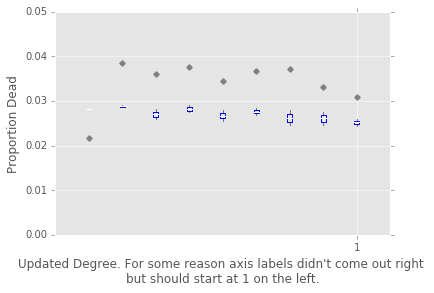

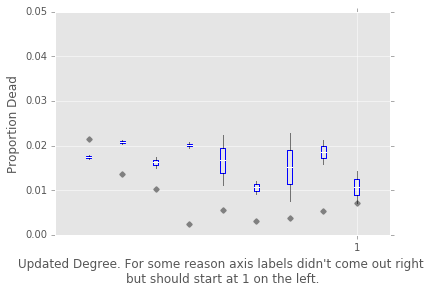

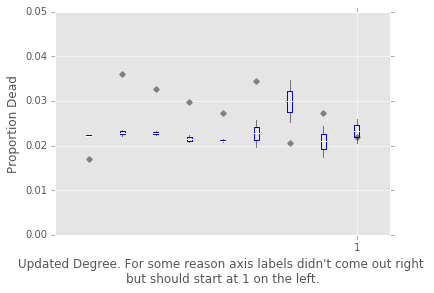

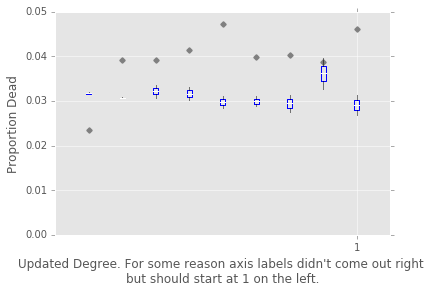

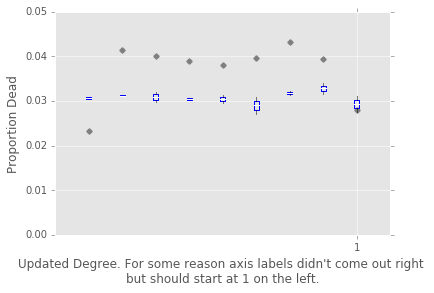

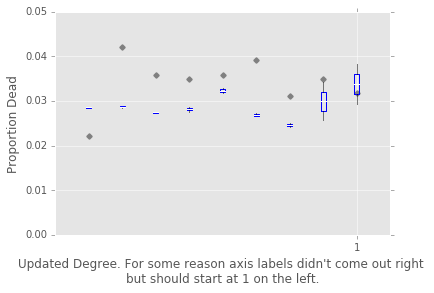

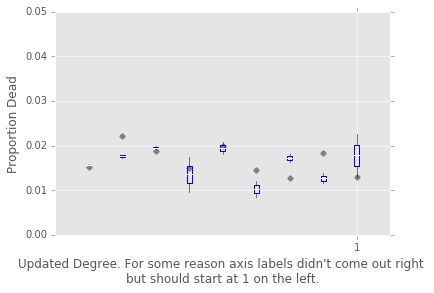

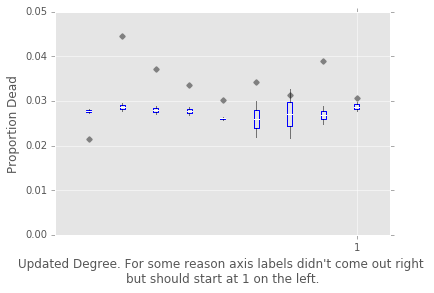

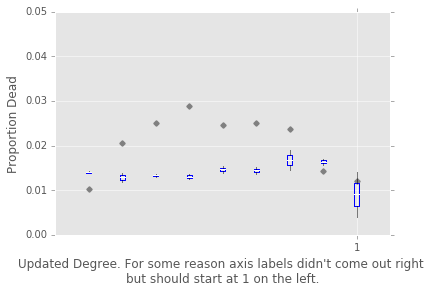

In [10]:
for death_years in results.keys():
    fig = plt.figure() #create figure
    ax = fig.add_subplot(1,1,1) #add axes
    updtdegs = range(1, 10)
    for updtdeg in updtdegs:
        monte_carlo = [mc_res[death_years][updtdeg][2] for mc_res in mc_results]
        actual = results[death_years][updtdeg][2]
        MonteCarloBoxPlot(monte_carlo, actual, ax, info=str(updtdeg), xpos=updtdeg)
    ax.set_xlim(min(updtdegs)-1, max(updtdegs)+1)
    ax.set_ylim(0, 0.05)
    ax.set_xticklabels(updtdegs)
    ax.set_xlabel('Updated Degree. For some reason axis labels didn\'t come out right \n' \
                     'but should start at 1 on the left.')
    ax.set_ylabel('Proportion Dead')
    plt.savefig(os.path.join(
                            project_root, 'reports', 'figures', 'updated_degree_boxplots_addflows',
                            'updated_degree_boxplots' + str(death_years)+ '_addflows_' + '.png'))

In [ ]:
s=1
l=10
plt.plot(act_prop_dead.keys()[s:l], act_prop_dead.values()[s:l], label='actual')
plt.plot(mcavg_prop_dead.keys()[s-1:l], mcavg_prop_dead.values()[s-1:l], label= 'mc average')
plt.xlabel('Updated Degree')
plt.ylabel('Proportion Dead')
plt.legend()
plt.savefig(os.path.join(
                        project_root, 'reports', 'figures',
                        'updated_degree_average.png'))